# Cell-type deconvolution using Tangram

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.1
tangram==0.4.0


We will load the public data available in Squidpy.

In [2]:
adata_st = sc.read_h5ad('../data/st_visp4.h5ad')

In [3]:
adata_st

AnnData object with n_obs × n_vars = 300 × 4258
    obs: 'in_tissue', 'array_row', 'array_col', 'mouse', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'library_id_colors', 'mouse_colors', 'neighbors', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'Scanorama', 'X_pca', 'X_scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [4]:
# Revert back to raw matrix to have all genes
adata_st = adata_st.raw.to_adata()


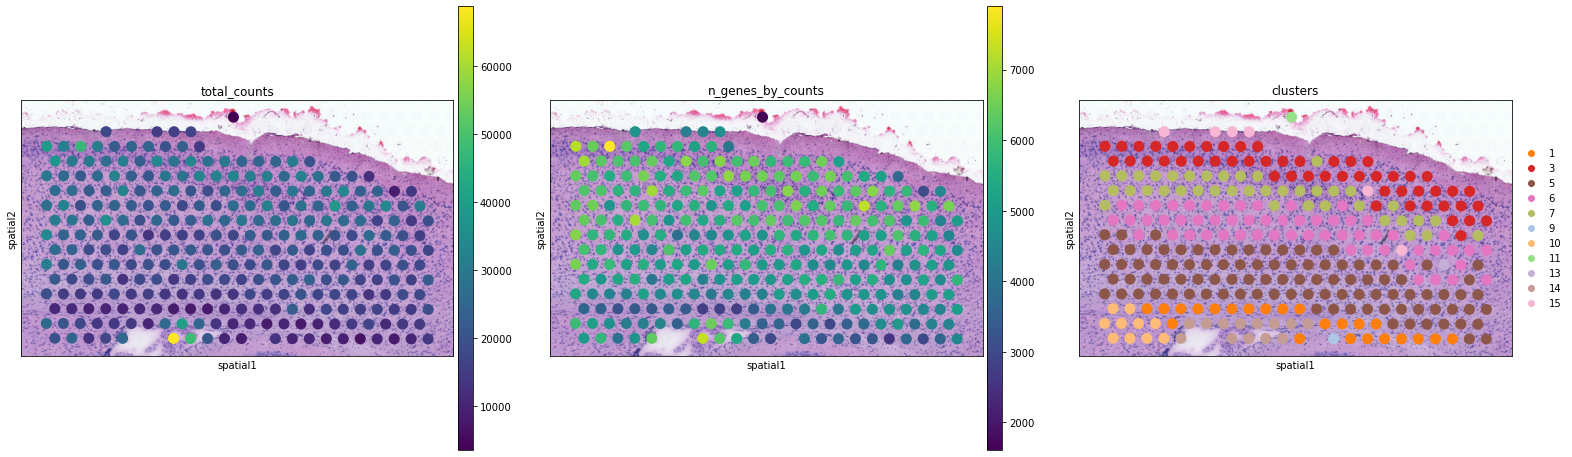

In [5]:
sample = 'ST8059051'

plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata_st, img_key="hires", color=["total_counts", "n_genes_by_counts","clusters"], library_id = sample)



## Create the image container

In [6]:
# check scalefactors
sf = adata_st.uns["spatial"][sample]["scalefactors"]["tissue_hires_scalef"]
sf

0.11640766

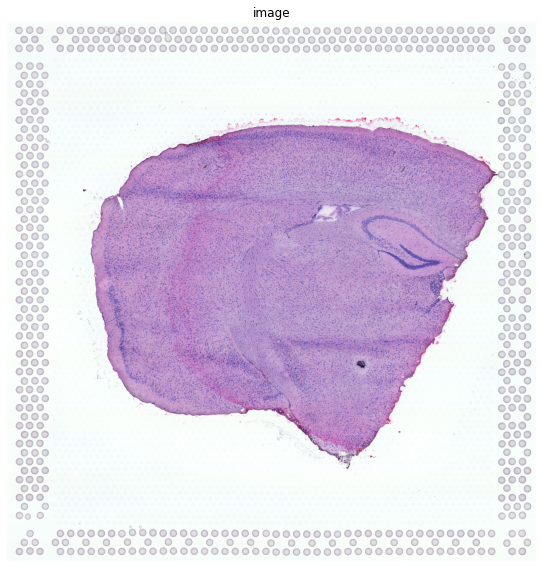

In [7]:
img = sq.im.ImageContainer(adata_st.uns['spatial'][sample]['images']['hires'], scale = sf)

#img = sq.im.ImageContainer(img,
#                           dims=("channels", "y", "x"),
#                           layer="img1",
#                           scale = sf,
#                           library_id = sample,
#                          )

img.show()

## Load SC data

In [8]:
# load sc data

adata_sc = sc.read_h5ad('../data/sc_visp_subsampled200.h5ad')

In [9]:
adata_sc

AnnData object with n_obs × n_vars = 3714 × 1500
    obs: 'title', 'source_name', 'organism', 'donor_id', 'donor_sex', 'donor_genotype', 'injection_type', 'injection_target', 'injected_material', 'dissected_region', 'dissected_layer', 'facs_gating', 'facs_date', 'rna_amplification_set', 'sequencing_tube', 'sequencing_batch', 'sequencing_qc_pass_fail', 'cell_class', 'cell_subclass', 'cell_cluster', 'molecule', 'SRA_Run', 'GEO_Sample', 'GEO_Sample_Title', 'clusters', 'batch'
    var: 'gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_class_colors', 'cell_cluster_colors', 'cell_subclass_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'

In [10]:
# revert back to raw
adata_sc = adata_sc.raw.to_adata()

In [11]:
adata_sc.obs['cell_subclass'].value_counts()

Vip           200
Lamp5         200
L2/3 IT       200
L4            200
L5 IT         200
L5 PT         200
L6 CT         200
L6 IT         200
L6b           200
Astro         200
NP            200
Pvalb         200
Sncg          200
Sst           200
Oligo         186
Endo          166
VLMC          133
Macrophage    131
SMC           109
Serpinf1       85
Meis2          55
Peri           32
CR             17
Name: cell_subclass, dtype: int64

## For plotting we need:
- the number of unique segmentation objects (i.e. nuclei) under each spot.
- the coordinates of the centroids of the segmentation object.


Skip nuclei segmentation, and run without information on cell numbers.

## Deconvolution and mapping
At this stage, we have all we need for the deconvolution task. 
First, we need to find a set of common genes the single cell and spatial datasets. 
We will use the top 100 DEGs per single cell cluster. Other common gene sets are variable genes in SC data, intersection of the highly variable genes from both datasets.

In [12]:
adata_sc

AnnData object with n_obs × n_vars = 3714 × 45768
    obs: 'title', 'source_name', 'organism', 'donor_id', 'donor_sex', 'donor_genotype', 'injection_type', 'injection_target', 'injected_material', 'dissected_region', 'dissected_layer', 'facs_gating', 'facs_date', 'rna_amplification_set', 'sequencing_tube', 'sequencing_batch', 'sequencing_qc_pass_fail', 'cell_class', 'cell_subclass', 'cell_cluster', 'molecule', 'SRA_Run', 'GEO_Sample', 'GEO_Sample_Title', 'clusters', 'batch'
    uns: 'cell_class_colors', 'cell_cluster_colors', 'cell_subclass_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'

In [13]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass")

In [14]:
# Make df with top 100 genes per cluster

markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_st.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
print(len(genes))

gene_file = "../data/tangram_genes.txt"
with open(gene_file, 'w') as filehandle:
    for x in genes:
        filehandle.write('%s\n' % x)

1270


In [15]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1247 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:15965 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Now we are ready to instantiate the model object and its hyper parameters. Note that we are loading `torch` and training the model on the GPU. However, it's also possible to train it on the CPU, it will just be slower.

In [16]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
#    mode="constrained",
#    target_count=adata_st.obs.cell_count.sum(),
#    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1247 genes and None density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.666
Score: 0.763
Score: 0.765
Score: 0.765
Score: 0.765
Score: 0.765
Score: 0.765
Score: 0.765
Score: 0.765
Score: 0.765


INFO:root:Saving results..


In [17]:
ad_map

AnnData object with n_obs × n_vars = 3714 × 300
    obs: 'title', 'source_name', 'organism', 'donor_id', 'donor_sex', 'donor_genotype', 'injection_type', 'injection_target', 'injected_material', 'dissected_region', 'dissected_layer', 'facs_gating', 'facs_date', 'rna_amplification_set', 'sequencing_tube', 'sequencing_batch', 'sequencing_qc_pass_fail', 'cell_class', 'cell_subclass', 'cell_cluster', 'molecule', 'SRA_Run', 'GEO_Sample', 'GEO_Sample_Title', 'clusters', 'batch'
    var: 'in_tissue', 'array_row', 'array_col', 'mouse', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'clusters', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [18]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [19]:
# add predictions to adata_st

adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


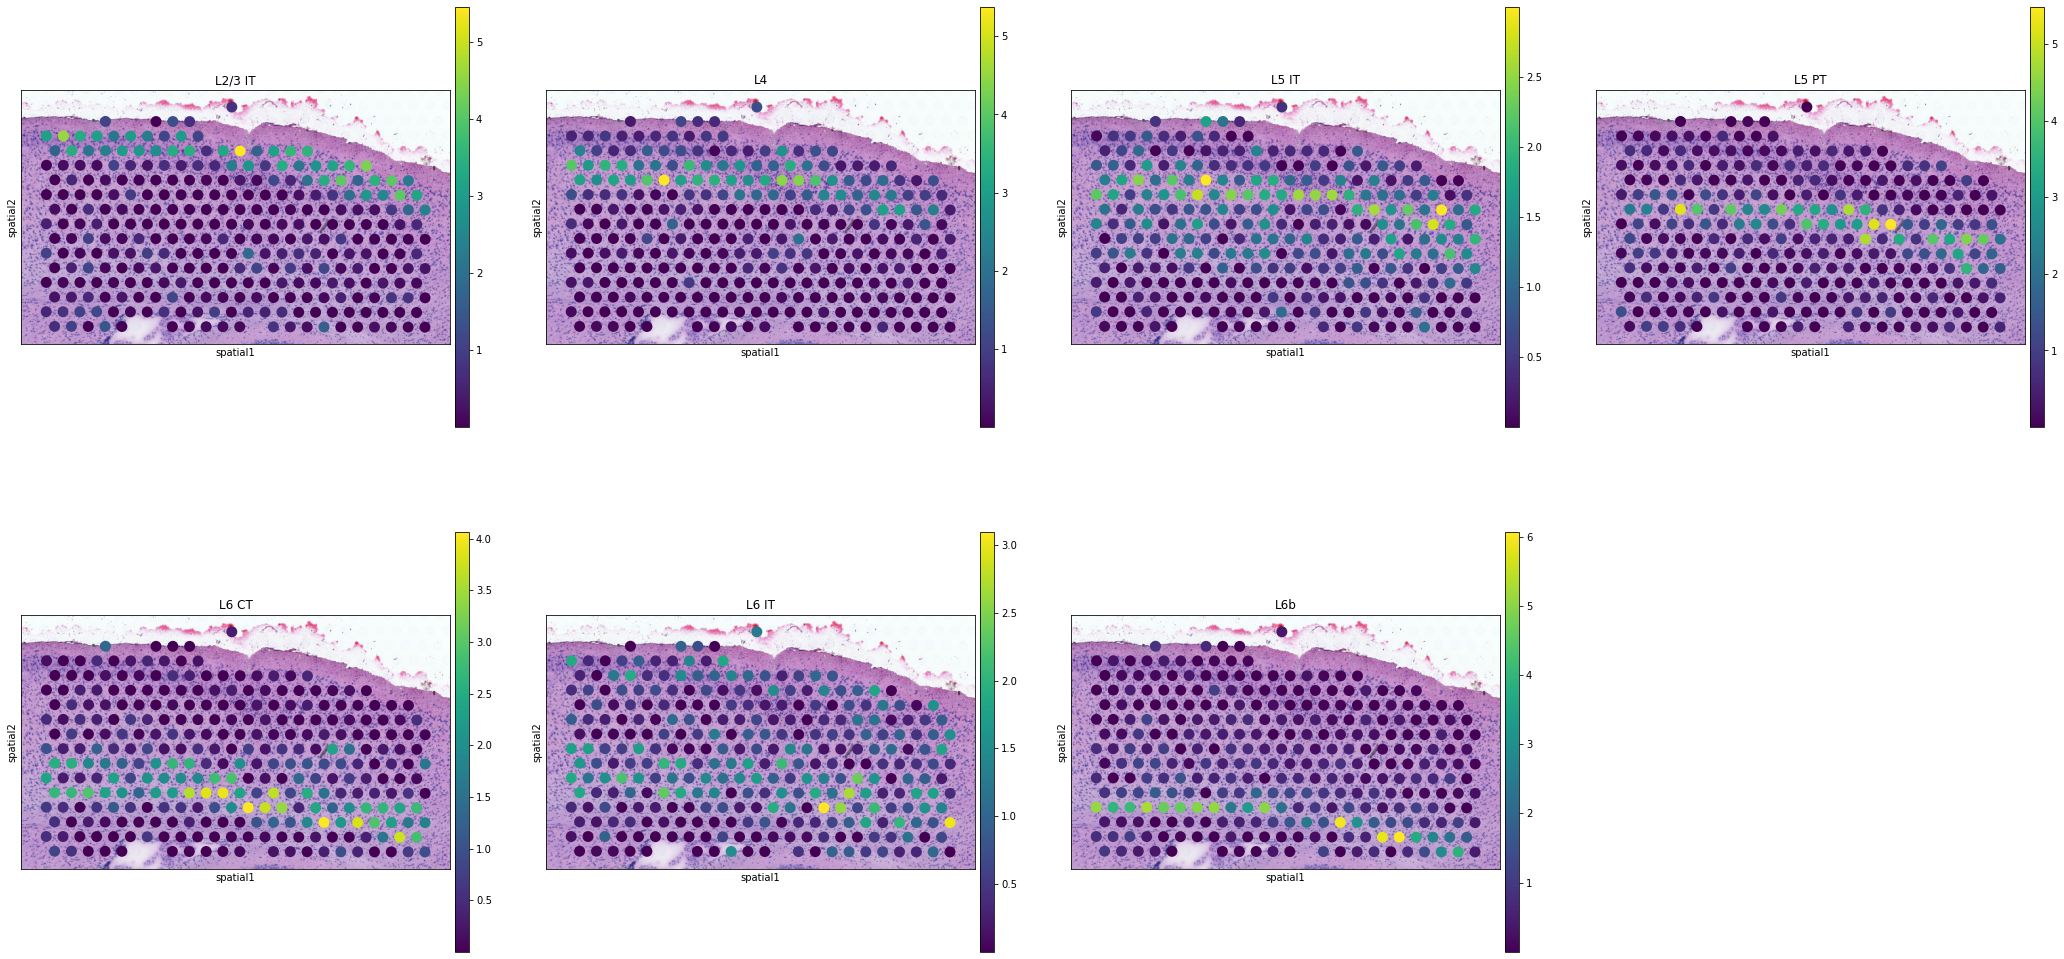

In [20]:

sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
)

In [21]:
adata_st.obsm["tangram_ct_pred"]

,Astro,CR,Endo,L2/3 IT,L4,L5 IT,L5 PT,L6 CT,L6 IT,L6b,...,NP,Oligo,Peri,Pvalb,SMC,Serpinf1,Sncg,Sst,VLMC,Vip
AAACAGAGCGACTCCT-1-ST8059051,0.737857,0.014405,0.685815,0.879346,3.332902,0.531040,0.000584,0.124216,0.587573,0.000134,...,0.000152,0.000149,0.033828,0.781656,0.156259,1.052451,0.732740,0.913972,0.168534,0.448775
AAACTCGTGATATAAG-1-ST8059051,0.518010,0.000047,0.694534,0.000235,0.000341,0.000171,0.515745,1.775816,3.013900,0.411729,...,1.122851,0.000198,0.213341,0.411360,0.130434,0.288188,1.089545,0.200398,0.209652,0.316790
AAATAACCATACGGGA-1-ST8059051,0.968951,0.663593,0.456833,0.617405,2.831277,0.501782,0.760529,0.185376,0.486945,0.000108,...,0.617243,0.000198,0.212495,1.119673,0.447020,0.508882,0.632288,0.565382,0.216938,0.177642
AAATGATTCGATCAGC-1-ST8059051,0.751731,0.000024,0.393991,0.261230,0.001174,0.853495,1.806970,0.604484,1.757683,0.162901,...,1.517374,0.000179,0.000095,0.384188,1.092717,0.316808,0.215152,1.323045,0.000106,0.792656
AAATGGCATGTCTTGT-1-ST8059051,0.670441,0.000029,0.745238,1.690781,2.427705,0.289670,0.679565,0.000107,0.298345,0.000082,...,0.058063,0.000090,0.099665,2.504097,0.000123,0.241195,0.298156,0.918900,0.198383,0.908273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGATGTGTAGTCCCG-1-ST8059051,0.883038,0.084225,1.141373,0.000512,0.000366,1.038875,0.000224,0.000192,0.000366,0.001740,...,0.481038,2.564591,0.000069,0.637095,1.245322,0.000104,0.979763,0.482153,0.902948,0.629233
TTGCGTGAACGCTTAG-1-ST8059051,0.554279,0.000039,0.729079,3.361326,1.975338,0.000445,0.072349,0.000093,0.242625,0.000115,...,0.020512,0.606230,0.102196,0.655897,0.119914,0.377303,1.135267,0.610459,0.334215,0.743229
TTGCTCCCATACCGGA-1-ST8059051,0.711076,0.029010,0.951488,0.000467,0.005609,0.189348,0.000317,0.000311,0.694924,4.115133,...,1.840584,0.994533,0.210538,0.000397,0.111406,0.269315,0.000168,0.174225,0.211608,1.838138
TTGGCCTAGAATTTCG-1-ST8059051,0.773751,0.023474,0.711743,0.000386,0.857837,1.396129,0.437893,0.002980,0.754950,0.406251,...,1.138552,1.083658,0.137305,0.506347,0.000136,0.000052,0.760066,0.819884,0.238034,0.000319


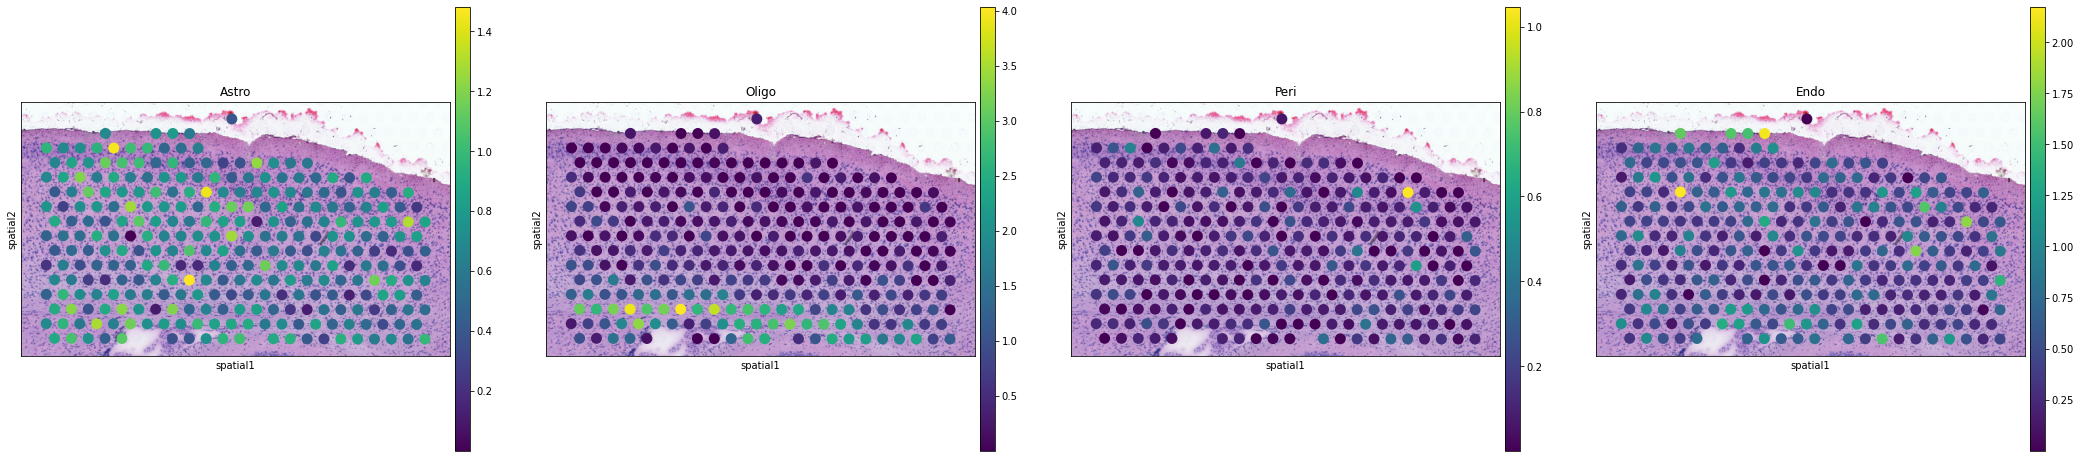

In [22]:
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=["Astro", "Oligo", "Peri", "Endo"],
)
